In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import random
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [5]:
# Load train and test datasets
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

In [6]:
# Hyperparameters
K = 270
hidden_size = 128
num_epochs = 30
batch_size = 64
learning_rate = 0.001
weight_decay = 0.001
dropout_prob = 0.85

In [7]:
# Define a function to preprocess the data
def preprocess_data(data):
    data = data.drop(columns=["Handle"])

    def preprocess_tweet(tweet):
        if isinstance(tweet, str):
            tweet = tweet.translate(str.maketrans('', '', string.punctuation)).lower()
            stop_words = set(stopwords.words("english"))
            tweet = [word for word in word_tokenize(tweet) if word not in stop_words]
            K = 10
            tweet = tweet[:K] + [""] * (K - len(tweet))
            return " ".join(tweet)
        else:
            return ""

    data["Tweet"] = data["Tweet"].apply(preprocess_tweet)

    data["Party"] = data["Party"].apply(lambda x: 1 if x == "Democrat" else 0)

    X = data.drop(columns=["Party"]).to_numpy()
    y = data["Party"].to_numpy()

    return X, y

In [9]:
# Preprocess the training and test data
X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)


In [10]:
# Build vocabulary and word-to-index mapping
vocab = Counter()
for tweet in X_train:
    vocab.update(tweet)

In [11]:
# Create a word-to-index mapping
word_to_idx = {word: i + 1 for i, (word, _) in enumerate(vocab.most_common())}
word_to_idx["<PAD>"] = 0

In [12]:
# Convert words to indices
def words_to_indices(words):
    indices = [word_to_idx[word] for word in words if word in word_to_idx]
    if len(indices) < K:
        indices += [word_to_idx["<PAD>"]] * (K - len(indices))
    return indices

In [13]:
X_train = torch.LongTensor([words_to_indices(tweet) for tweet in X_train])
X_test = torch.LongTensor([words_to_indices(tweet) for tweet in X_test])
y_train = torch.LongTensor([1 if party == "Democrat" else 0 for party in y_train])
y_test = torch.LongTensor([1 if party == "Democrat" else 0 for party in y_test])


In [14]:
# Create DataLoader for training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [15]:
# Define the Feedforward Neural Network (FFNN) model
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [16]:
# Define different hyperparameters, regularization techniques, and optimizers
hyperparameters = [
    {"learning_rate": 0.001, "weight_decay": 0.001, "dropout_prob": 0.85},
    {"learning_rate": 0.01, "weight_decay": 0.001, "dropout_prob": 0.7},
    {"learning_rate": 0.001, "weight_decay": 0.01, "dropout_prob": 0.5}
]

optimizers = [
    {"name": "SGD", "optimizer": optim.SGD},
    {"name": "RMSprop", "optimizer": optim.RMSprop},
    {"name": "Adam", "optimizer": optim.Adam}
]


In [17]:
# Perform experiments with different hyperparameters and optimizers
results = []

for hp in hyperparameters:
    for optimizer_info in optimizers:
        optimizer_name = optimizer_info["name"]
        optimizer = optimizer_info["optimizer"]

        model = FFNN(K, hidden_size, 1, hp["dropout_prob"])
        criterion = nn.BCEWithLogitsLoss()
        optimizer_instance = optimizer(model.parameters(), lr=hp["learning_rate"], weight_decay=hp["weight_decay"])

        print(f"Training model using {optimizer_name}, Learning Rate: {hp['learning_rate']}, Weight Decay: {hp['weight_decay']}, Dropout: {hp['dropout_prob']}")
        optimizer_instance.zero_grad()

        for epoch in range(num_epochs):
            for i, (inputs, labels) in enumerate(train_loader):
                outputs = model(inputs.float())
                loss = criterion(outputs.squeeze(), labels.float())

                loss.backward()
                optimizer_instance.step()
                optimizer_instance.zero_grad()
                if (i + 1) % 10 == 0:
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Evaluate the model on the test set
        with torch.no_grad():
            outputs = model(X_test.float())
            preds = (outputs.squeeze() > 0).long()
            acc = accuracy_score(y_test, preds)
            results.append({
                "Hyperparameters": hp,
                "Optimizer": optimizer_name,
                "Accuracy": acc
            })
            print(f"Accuracy using {optimizer_name}: {acc:.4f}")


Streaming output truncated to the last 5000 lines.
Epoch [16/30], Batch [890/1137], Loss: 0.6931
Epoch [16/30], Batch [900/1137], Loss: 0.6931
Epoch [16/30], Batch [910/1137], Loss: 0.6931
Epoch [16/30], Batch [920/1137], Loss: 0.6931
Epoch [16/30], Batch [930/1137], Loss: 0.6931
Epoch [16/30], Batch [940/1137], Loss: 0.6932
Epoch [16/30], Batch [950/1137], Loss: 0.6931
Epoch [16/30], Batch [960/1137], Loss: 0.6931
Epoch [16/30], Batch [970/1137], Loss: 0.6932
Epoch [16/30], Batch [980/1137], Loss: 0.6931
Epoch [16/30], Batch [990/1137], Loss: 0.6932
Epoch [16/30], Batch [1000/1137], Loss: 0.6932
Epoch [16/30], Batch [1010/1137], Loss: 0.6931
Epoch [16/30], Batch [1020/1137], Loss: 0.6931
Epoch [16/30], Batch [1030/1137], Loss: 0.6931
Epoch [16/30], Batch [1040/1137], Loss: 0.6932
Epoch [16/30], Batch [1050/1137], Loss: 0.6931
Epoch [16/30], Batch [1060/1137], Loss: 0.6931
Epoch [16/30], Batch [1070/1137], Loss: 0.6932
Epoch [16/30], Batch [1080/1137], Loss: 0.6931
Epoch [16/30], Batch

In [18]:
#Pandas DataFrame for tabulating the results
results_df = pd.DataFrame(results)

In [19]:
# Print the tabulated results
print(results_df)

                                     Hyperparameters Optimizer  Accuracy
0  {'learning_rate': 0.001, 'weight_decay': 0.001...       SGD  0.023605
1  {'learning_rate': 0.001, 'weight_decay': 0.001...   RMSprop  0.018214
2  {'learning_rate': 0.001, 'weight_decay': 0.001...      Adam  0.019306
3  {'learning_rate': 0.01, 'weight_decay': 0.001,...       SGD  0.035334
4  {'learning_rate': 0.01, 'weight_decay': 0.001,...   RMSprop  0.021929
5  {'learning_rate': 0.01, 'weight_decay': 0.001,...      Adam  0.031400
6  {'learning_rate': 0.001, 'weight_decay': 0.01,...       SGD  0.019816
7  {'learning_rate': 0.001, 'weight_decay': 0.01,...   RMSprop  0.016101
8  {'learning_rate': 0.001, 'weight_decay': 0.01,...      Adam  0.017267


In [ ]:
results_df.to_csv('withoutHandle.csv', index=False)

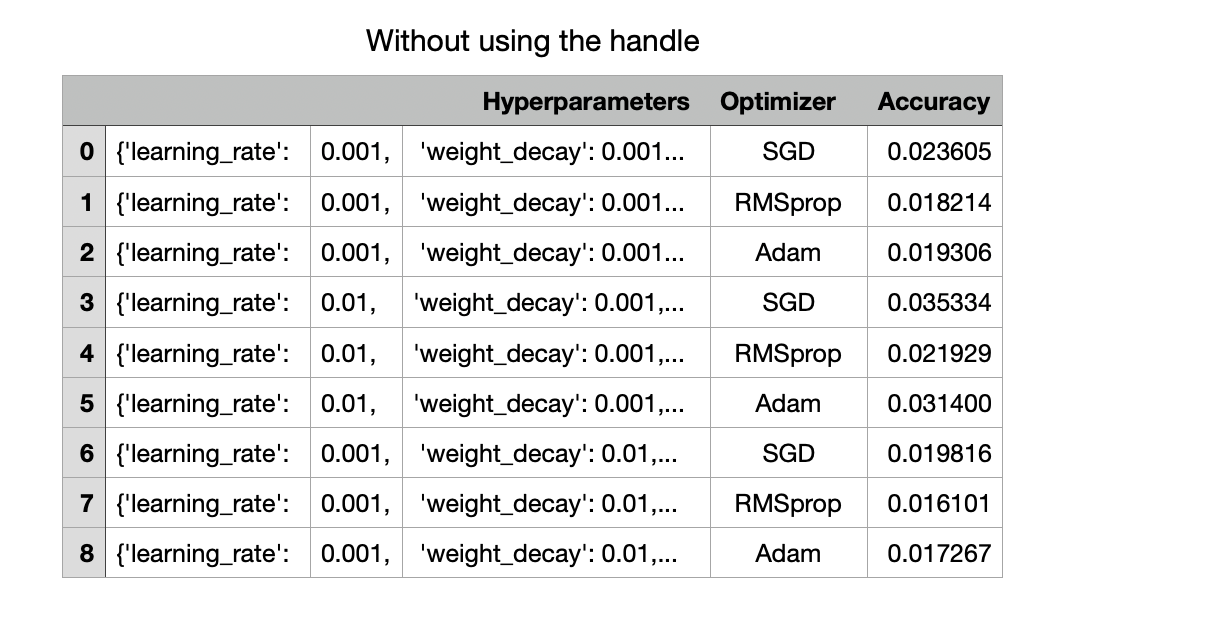

## Using the handle

In [56]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [20]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [21]:
# Load train and test datasets
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

In [46]:
# Hyperparameters
K = 270
hidden_size = 128
num_epochs = 30
batch_size = 64
learning_rate = 0.001
weight_decay = 0.001
dropout_prob = 0.85

In [47]:
# Define a function to preprocess the data
def preprocess_data(data):
    data = data.drop(columns=["Handle"])

    def preprocess_tweet(tweet):
        if isinstance(tweet, str):
            tweet = tweet.translate(str.maketrans('', '', string.punctuation)).lower()
            stop_words = set(stopwords.words("english"))
            tweet = [word for word in word_tokenize(tweet) if word not in stop_words]
            K = 10
            tweet = tweet[:K] + [""] * (K - len(tweet))
            return " ".join(tweet)
        else:
            return ""

    data["Tweet"] = data["Tweet"].apply(preprocess_tweet)

    data["Party"] = data["Party"].apply(lambda x: 1 if x == "Democrat" else 0)

    X = data.drop(columns=["Party"]).to_numpy()
    y = data["Party"].to_numpy()

    return X, y

In [57]:
# Preprocess the training and test data
X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

In [58]:
# Build vocabulary and word-to-index mapping for tweets
tweet_vocab = Counter()
for tweet in X_train[:, 0]:
    tweet_vocab.update(tweet)

In [59]:
# Create a word-to-index mapping for tweets
tweet_word_to_idx = {word: i + 1 for i, (word, _) in enumerate(tweet_vocab.most_common())}
tweet_word_to_idx["<PAD>"] = 0

In [60]:
# Convert words to indices for tweets
def tweet_words_to_indices(words):
    indices = [tweet_word_to_idx[word] for word in words if word in tweet_word_to_idx]
    if len(indices) < K:
        indices += [tweet_word_to_idx["<PAD>"]] * (K - len(indices))
    return indices

X_train_tweets = torch.LongTensor([tweet_words_to_indices(tweet) for tweet in X_train[:, 0]])
X_test_tweets = torch.LongTensor([tweet_words_to_indices(tweet) for tweet in X_test[:, 0].astype(str)])


In [61]:
# Build vocabulary and word-to-index mapping for handles
handle_vocab = Counter()
for handle in X_train[:, 1]:
    handle_vocab.update(handle)

In [64]:
# Convert words to indices for handles
def handle_words_to_indices(words):
    indices = [handle_word_to_idx[word] if word in handle_word_to_idx else 0 for word in words]
    if len(indices) < K:
        indices += [0] * (K - len(indices))  # Use 0 for padding if word is not found
    return indices

X_train_handles = torch.LongTensor([handle_words_to_indices(handle) for handle in X_train[:, 1]])
X_test_handles = torch.LongTensor([handle_words_to_indices(handle) for handle in X_test[:, 1]])

y_train = torch.LongTensor([1 if party == "Democrat" else 0 for party in y_train])
y_test = torch.LongTensor([1 if party == "Democrat" else 0 for party in y_test])


In [65]:
# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tweets, X_train_handles, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [66]:
# Define the Feedforward Neural Network (FFNN) model
class FFNN(nn.Module):
    def __init__(self, input_size_tweets, input_size_handles, hidden_size, output_size, dropout_prob):
        super(FFNN, self).__init__()
        self.fc_tweets = nn.Linear(input_size_tweets, hidden_size)
        self.fc_handles = nn.Linear(input_size_handles, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc_combined = nn.Linear(hidden_size * 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_tweets, x_handles):
        x_tweets = self.fc_tweets(x_tweets)
        x_handles = self.fc_handles(x_handles)
        x_combined = torch.cat((x_tweets, x_handles), dim=1)
        x_combined = self.dropout(x_combined)
        x_combined = self.fc_combined(x_combined)
        x_combined = self.sigmoid(x_combined)
        return x_combined

In [67]:
# Define different hyperparameters, regularization techniques, and optimizers
hyperparameters = [
    {"learning_rate": 0.001, "weight_decay": 0.001, "dropout_prob": 0.85},
    {"learning_rate": 0.01, "weight_decay": 0.001, "dropout_prob": 0.7},
    {"learning_rate": 0.001, "weight_decay": 0.01, "dropout_prob": 0.5}
]

optimizers = [
    {"name": "SGD", "optimizer": optim.SGD},
    {"name": "RMSprop", "optimizer": optim.RMSprop},
    {"name": "Adam", "optimizer": optim.Adam}
]



In [68]:
# Perform experiments with different hyperparameters and optimizers
results = []

for hp in hyperparameters:
    for optimizer_info in optimizers:
        optimizer_name = optimizer_info["name"]
        optimizer = optimizer_info["optimizer"]

        model = FFNN(K, K, hidden_size, 1, hp["dropout_prob"])
        criterion = nn.BCELoss()
        optimizer_instance = optimizer(model.parameters(), lr=hp["learning_rate"], weight_decay=hp["weight_decay"])

        print(f"Training model using {optimizer_name}, Learning Rate: {hp['learning_rate']}, Weight Decay: {hp['weight_decay']}, Dropout: {hp['dropout_prob']}")
        optimizer_instance.zero_grad()

        for epoch in range(num_epochs):
            for i, (inputs_tweets, inputs_handles, labels) in enumerate(train_loader):
                outputs = model(inputs_tweets.float(), inputs_handles.float())
                loss = criterion(outputs.squeeze(), labels.float())

                loss.backward()
                optimizer_instance.step()
                optimizer_instance.zero_grad()
                if (i + 1) % 10 == 0:
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # Evaluate the model on the test set
        with torch.no_grad():
            outputs = model(X_test_tweets.float(), X_test_handles.float())
            preds = (outputs.squeeze() > 0.5).long()
            acc = accuracy_score(y_test, preds)
            results.append({
                "Hyperparameters": hp,
                "Optimizer": optimizer_name,
                "Accuracy": acc
            })
            print(f"Accuracy using {optimizer_name}: {acc:.4f}")

Streaming output truncated to the last 5000 lines.
Epoch [16/30], Batch [890/1137], Loss: 0.0013
Epoch [16/30], Batch [900/1137], Loss: 0.0015
Epoch [16/30], Batch [910/1137], Loss: 0.0010
Epoch [16/30], Batch [920/1137], Loss: 0.0012
Epoch [16/30], Batch [930/1137], Loss: 0.0006
Epoch [16/30], Batch [940/1137], Loss: 0.0033
Epoch [16/30], Batch [950/1137], Loss: 0.0017
Epoch [16/30], Batch [960/1137], Loss: 0.0013
Epoch [16/30], Batch [970/1137], Loss: 0.0019
Epoch [16/30], Batch [980/1137], Loss: 0.0015
Epoch [16/30], Batch [990/1137], Loss: 0.0008
Epoch [16/30], Batch [1000/1137], Loss: 0.0011
Epoch [16/30], Batch [1010/1137], Loss: 0.0009
Epoch [16/30], Batch [1020/1137], Loss: 0.0009
Epoch [16/30], Batch [1030/1137], Loss: 0.0030
Epoch [16/30], Batch [1040/1137], Loss: 0.0009
Epoch [16/30], Batch [1050/1137], Loss: 0.0018
Epoch [16/30], Batch [1060/1137], Loss: 0.0014
Epoch [16/30], Batch [1070/1137], Loss: 0.0020
Epoch [16/30], Batch [1080/1137], Loss: 0.0017
Epoch [16/30], Batch

In [69]:
# Display the results in tabular format
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)

                                     Hyperparameters Optimizer  Accuracy
0  {'learning_rate': 0.001, 'weight_decay': 0.001...       SGD       1.0
1  {'learning_rate': 0.001, 'weight_decay': 0.001...   RMSprop       1.0
2  {'learning_rate': 0.001, 'weight_decay': 0.001...      Adam       1.0
3  {'learning_rate': 0.01, 'weight_decay': 0.001,...       SGD       1.0
4  {'learning_rate': 0.01, 'weight_decay': 0.001,...   RMSprop       1.0
5  {'learning_rate': 0.01, 'weight_decay': 0.001,...      Adam       1.0
6  {'learning_rate': 0.001, 'weight_decay': 0.01,...       SGD       1.0
7  {'learning_rate': 0.001, 'weight_decay': 0.01,...   RMSprop       1.0
8  {'learning_rate': 0.001, 'weight_decay': 0.01,...      Adam       1.0


In [71]:
results_df.to_csv('/content/withHandle.csv', index=False)

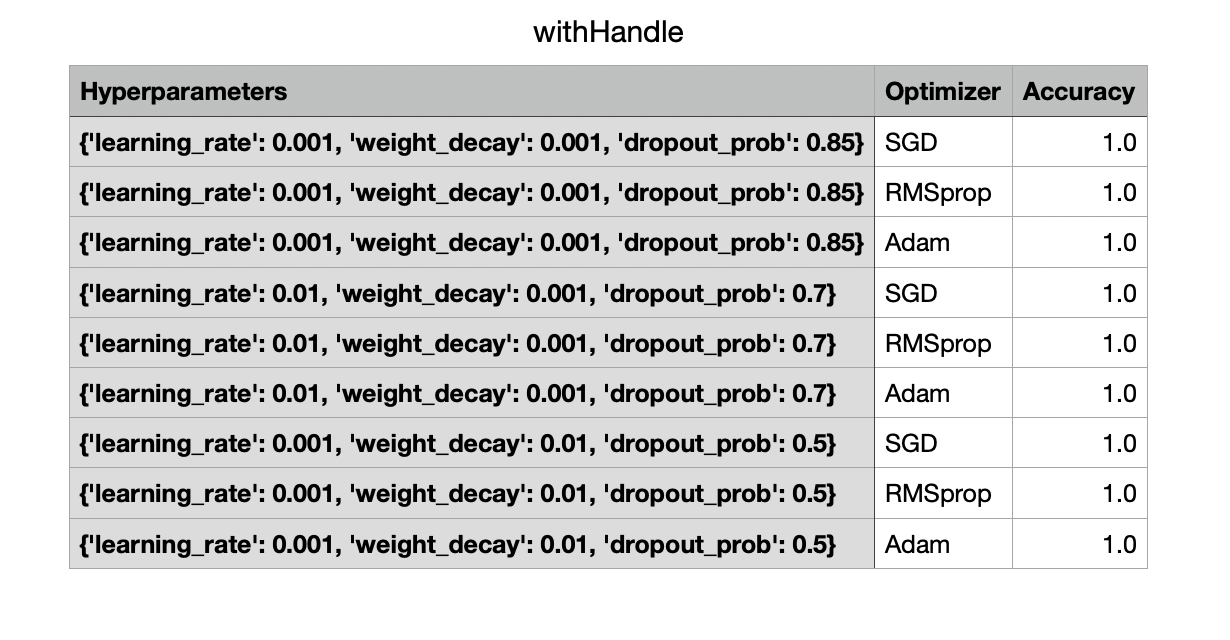